Machine learning algorithms are often described in two varieties: Unsupervised and Supervised learning. 

Unsupervised learning uses a class of algorithms that try to learn the inherent structure of the data without knowing any additional information about it. This includes clustering, feature extraction, and dimensionality reduction algorithms.

Supervised learning, on the other hand, uses 'labels': information that we know about the data (or at least a subset of the data) to understand the structure of the data in the specific context of the labels. These methods often use this knowledge to perform regression or classification type problems. 

Here we focus on a classification problem: reducing contamination in a galaxy sample due using information contained in their spectral energy distributions (SEDs).

## The three phases in a ML algorithm: 

1. Training - learning the structure of the data using a subset of available data.
2. Testing - testing on a different subset of data to calibrate the training step.
3. Cross-Validation - testing on an independent dataset to gauge accuracy and avoid overtraining

### Problem Statement:

Suppose I want to study a sample of galaxies at redshift 1, to understand something about the physical properties of galaxies at that epoch. My galaxy sample, however, contains galaxies at other redshifts as well, which could bias my results. Can I use some clustering algorithm to select my z~1 sample while minimizing the contamination from other galaxies?

For a subset of my galaxies, I have spectroscopically measured redshifts, using which I have created a training set. How can I use this effectively?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import time
import warnings
warnings.filterwarnings('ignore')

## let's import the catalog. 

In [3]:
# np.loadtxt and np.genfromtxt are both excellent tools to extract data from a variety of files.
# the SEDs are in units of log flux density

seds = np.genfromtxt('../../data/sed_samples.txt')

labels = np.genfromtxt('../../data/sed_zlabels.txt').ravel().astype(int)

# check the dimensionality of the data and the labels using

print('SED shape: ', seds.shape)

print('labels shape:', labels.shape)




SED shape:  (1633, 17)
labels shape: (1633,)


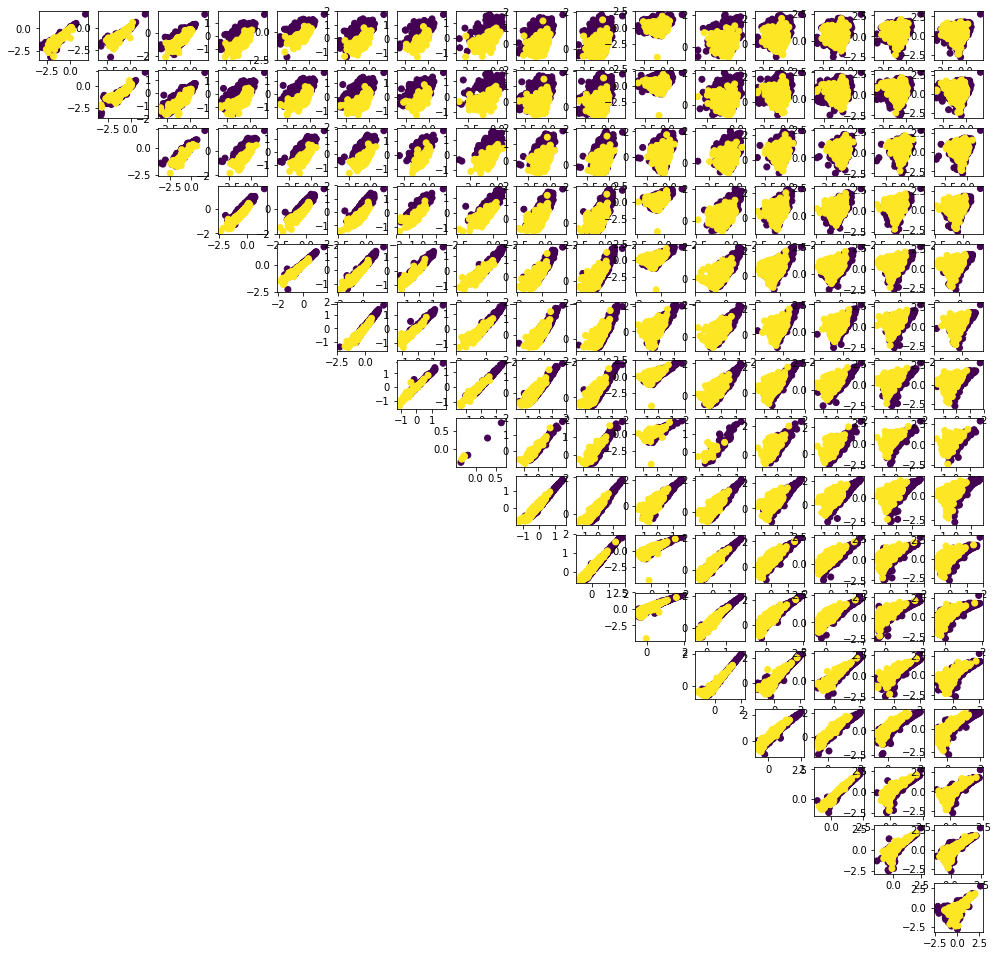

In [4]:
# visualize SED values for both datasets.

plt.figure(figsize=(18,18))
for i in range(seds.shape[1]):
    for j in range(i+1,seds.shape[1]):
        plt.subplot(seds.shape[1],seds.shape[1],(i+1)*seds.shape[1]+j)
        plt.scatter(seds[0:,i],seds[0:,j],c=labels)
plt.show()

This doesn't look very useful, as the two sets of data seem to overlap significantly. 

However, using some knowledge of astrophysics, we realize that the observed-frame colors (or an equivalent quantity related to the differences between different bands in the measured SEDs) might let us get a bit more information.

Let's try this, plotting colors on the y-axis and the flux densities along the x-axis as before.

(note that the quantities we use here aren't quite colors due to a conversion in scale that we've omitted for convenience.)

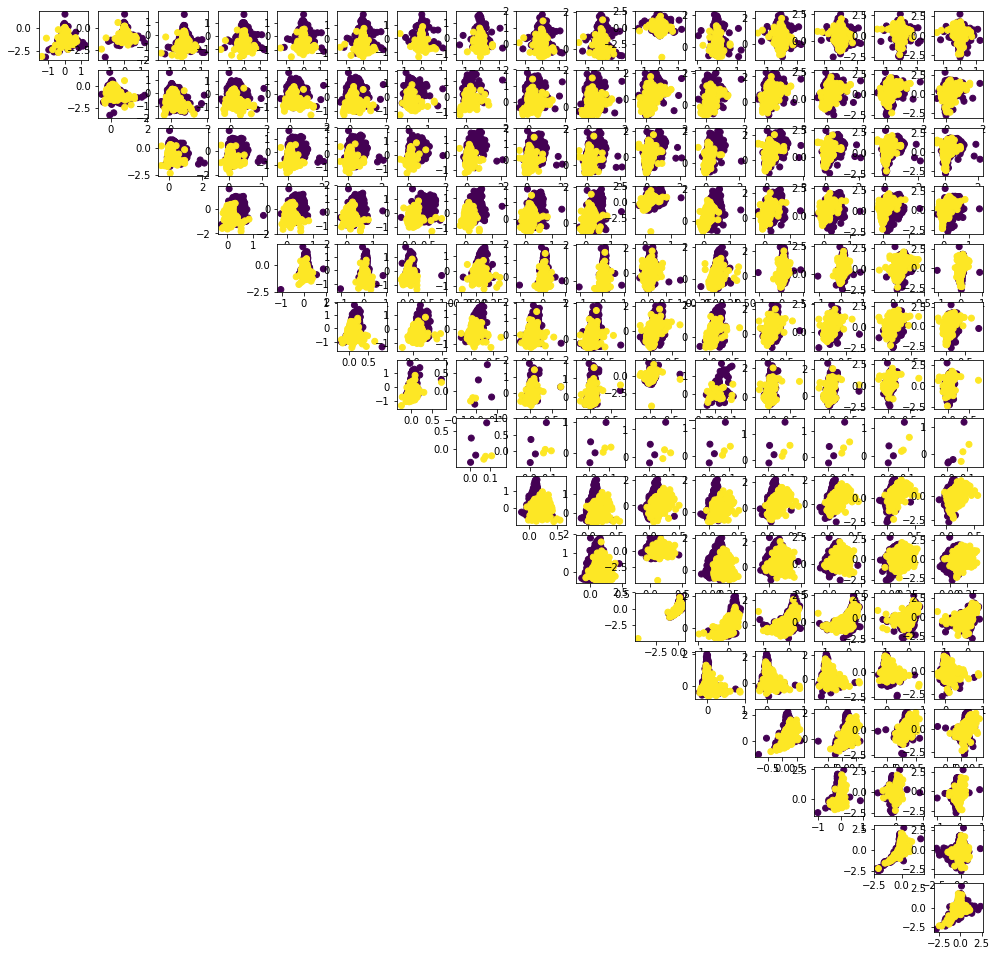

In [5]:
# visualize color-magnitude values for both datasets.

plt.figure(figsize=(18,18))
for i in range(seds.shape[1]-1):
    for j in range(i+1,seds.shape[1]):
        plt.subplot(seds.shape[1],seds.shape[1],(i+1)*seds.shape[1]+j)
        plt.scatter(seds[0:,i+1] - seds[0:,i],seds[0:,j],c=labels)
plt.show()

In [6]:
# Some of these columns look slightly more useful, so lets try clustering with them.

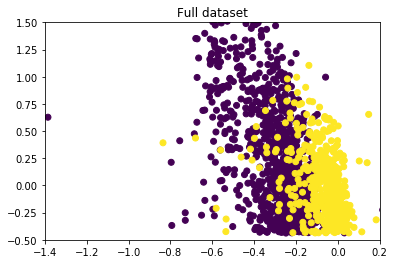

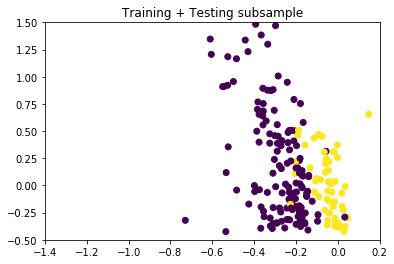

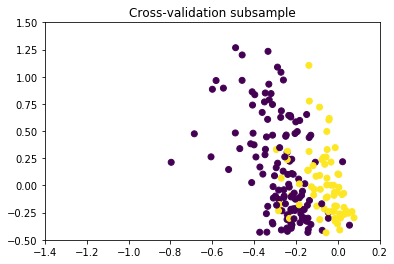

In [7]:
color_1 = seds[0:,3]-seds[0:,4]
mag_1 = seds[0:,10]

# since not all clustering algorithms will be able to deal with nan values, we remove them prior to fitting
good_mask = (~np.isnan(color_1)) & (~np.isnan(mag_1))

color_1_good = color_1[good_mask]
mag_1_good = mag_1[good_mask]
labels_good = labels[good_mask]

# let's split our data into training and cross_validation samples. 
# our training data will be further split into training and testing samples

ngals = 200

np.random.seed(12)
train_validn_mask = np.random.choice(np.arange(len(labels_good)), ngals*2, replace=False)

train_mask = train_validn_mask[0:ngals]
validn_mask = train_validn_mask[ngals:]

Xdata_train = np.concatenate((color_1_good[train_mask].reshape(1,-1), mag_1_good[train_mask].reshape(1,-1))).T
ydata_train = labels[train_mask]


Xdata_validn = np.concatenate((color_1_good[validn_mask].reshape(1,-1), mag_1_good[validn_mask].reshape(1,-1))).T
ydata_validn = labels[validn_mask]


# Let's plot the dataset and see how it looks:


plt.title('Full dataset')
plt.scatter(seds[0:,3]-seds[0:,4],seds[0:,10],c=labels)
plt.axis([-1.4,0.2,-0.5,1.5])
plt.show()

plt.title('Training + Testing subsample')
plt.scatter(Xdata_train[0:,0],Xdata_train[0:,1],c=ydata_train)
plt.axis([-1.4,0.2,-0.5,1.5])
plt.show()


plt.title('Cross-validation subsample')
plt.scatter(Xdata_validn[0:,0],Xdata_validn[0:,1],c=ydata_validn)
plt.axis([-1.4,0.2,-0.5,1.5])
plt.show()

In [8]:
# Let's see how this works with all the classifiers at our disposal:

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

datasets = [(Xdata_train, ydata_train)
            ]

 

## Summary of classifiers

Nearest neighbor classification (NN) classifies points by looking at the labels of its k nearest neighbors. This method works very well when the classes are separable, but not as well when there is significant overlap due to noise. Radius based classifiers that look within a radius r might be a better choice when the data is sampled sparsely / nonuniformly. Documentation [here](http://scikit-learn.org/stable/modules/neighbors.html). Wiki page [here](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#The_weighted_nearest_neighbour_classifier).

Support Vector Machines (SVM) extend the data into a higher-dimensional space where they can draw a hyperplane or other decision boundary separating the two populations to be classified. Documentation [here](http://scikit-learn.org/stable/modules/svm.html). Wiki page [here](https://en.wikipedia.org/wiki/Support_vector_machine).

Gaussian Process based Classification (GP) is a probabilistic classifier based on gaussian processes, an extension of the gaussion probability distribution to the space of functions. Documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html). Read more [here](http://www.gaussianprocess.org/gpml/).

Decision tree classification (DT) builds a model that describes the data using a simple set of decision rules. This is intuitively easy to understand, can work well with multidimensional data, and offer a host of visualisation capabilities for detected features. Disadvantages include poor scaling with dataset size, and susceptability to overtraining due to noise. Documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). Wiki page [here](https://en.wikipedia.org/wiki/Decision_tree_learning).

Random forest classification (RF) is an ensemble learning method that a fits a large number of decision trees to the same dataset and uses averaging to improve accuracy, and control overfitting. Documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Wiki page [here](https://en.wikipedia.org/wiki/Random_forest).

Neural nets (NN) construct a complex, multilinear mapping between the observables and the labels using a set of weights that are optimized in the training step. Documentation [here](http://scikit-learn.org/stable/modules/neural_networks_supervised.html). Wiki page [here](https://en.wikipedia.org/wiki/Artificial_neural_network).

Adaptive Boosting (AdaBoost) uses multiple 'weak' classifiers to build a strong classifier (ie. high correlation between classified and true labels) by focusing on harder cases in subsequent classifiers. The scikit-learn implementation uses decision trees, and can fit more detail in the dataset as the amount of boosts is increased. Documentation [here](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html). Wiki page [here](https://en.wikipedia.org/wiki/AdaBoost).

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of independence between every pair of features. Like gaussian process classification, this is also a probabilistic classifier. Documentation [here](http://scikit-learn.org/stable/modules/naive_bayes.html).

Quadratic Discriminant Analysis (QDA) is a classifier that uses a quadratic decision surface. Documentation [here](http://scikit-learn.org/stable/modules/lda_qda.html).

See the classifier comparison for a few other example datasets [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).


--------------------------------
training set shape:  (120, 2) (120,)
test set shape:  (80, 2) (80,)
time taken by Nearest Neighbors is 0.3251 sec with score: 0.925 .
time taken by Linear SVM is 0.2424 sec with score: 0.825 .
time taken by RBF SVM is 0.2959 sec with score: 0.925 .
time taken by Gaussian Process is 12.3817 sec with score: 0.925 .
time taken by Decision Tree is 0.1078 sec with score: 0.938 .
time taken by Random Forest is 0.3411 sec with score: 0.925 .
time taken by Neural Net is 0.5499 sec with score: 0.938 .
time taken by AdaBoost is 1.6649 sec with score: 0.912 .
time taken by Naive Bayes is 0.1440 sec with score: 0.912 .
time taken by QDA is 0.1270 sec with score: 0.925 .


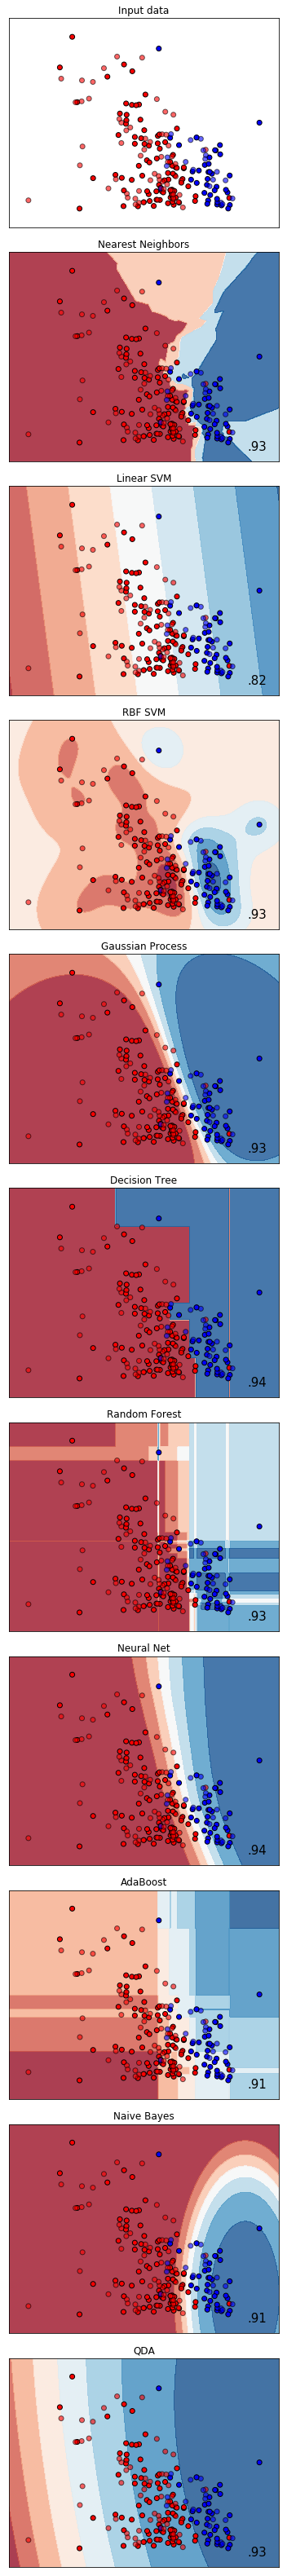

total time taken: 17.54 sec.


In [9]:
time_init = time.time()


test_size_frac = 0.4

cross_validation_results = np.zeros((len(Xdata_validn),len(classifiers)))


figure = plt.figure(figsize=(5,(len(classifiers)+1)*4))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=test_size_frac, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(classifiers) + 1, len(datasets), i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    print('--------------------------------')
    print('training set shape: ',X_train.shape, y_train.shape)
    print('test set shape: ',X_test.shape, y_test.shape) 
    

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        
        time_class_init = time.time()
        
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        
        Xdt = StandardScaler().fit_transform(Xdata_validn)
        #print(clf.predict(Xdt))
        
        cross_validation_results[0:,i-2] = clf.predict(Xdt)
        
        #print(name, score)
        
        
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        
        if X.shape[1] == 2:
            
            
            
            ax = plt.subplot(len(classifiers) +1, len(datasets), i)
        
            if hasattr(clf, "decision_function"):
                #print(clf.decision_function(Xdata_train))
                Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
            else:
                Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

            # Plot also the training points
            ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                       edgecolors='k')
            # and testing points
            ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                       edgecolors='k', alpha=0.6)

            ax.set_xlim(xx.min(), xx.max())
            ax.set_ylim(yy.min(), yy.max())
            ax.set_xticks(())
            ax.set_yticks(())
            if ds_cnt == 0:
                ax.set_title(name)
            ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                    size=15, horizontalalignment='right')
            i += 1
            
        time_class_end = time.time()
        print('time taken by '+name+' is %.4f sec'%(time_class_end-time_class_init)+' with score: %.3f .' %score )

plt.tight_layout()
plt.show()

time_finish = time.time()

print('total time taken: %.2f sec.' %(time_finish - time_init))

## Exercise: 

Write a small piece of code to evaluate the confusion matrix elements for each classifier:

In [ ]:


for i in range(len(classifiers)):
    
    print('--------------------')
    
    true_labels = ydata_validn
    predicted_labels = cross_validation_results[0:,i]
    
    #--------------------------------------------------------------------------------------------
    # your code goes here, and should create 4 variables: truepos, trueneg, falsepos, falseneg
    #--------------------------------------------------------------------------------------------
    
    print(names[i])
    print('True positive:', str(truepos), 'True negatives: ', str(trueneg))
    print('False positives:', str(falsepos), 'False negatives: ', str(falseneg))
    print('Total: ', str(truepos + trueneg + falsepos + falseneg), ', accuracy: %.4f' %((truepos+trueneg)/(truepos + trueneg + falsepos + falseneg)))
    

--------------------
Nearest Neighbors
True positive: 125 True negatives:  49
False positives: 6 False negatives:  20
Total:  200 , accuracy: 0.8700
--------------------
Linear SVM
True positive: 129 True negatives:  16
False positives: 2 False negatives:  53
Total:  200 , accuracy: 0.7250
--------------------
RBF SVM
True positive: 125 True negatives:  47
False positives: 6 False negatives:  22
Total:  200 , accuracy: 0.8600
--------------------
Gaussian Process
True positive: 122 True negatives:  51
False positives: 9 False negatives:  18
Total:  200 , accuracy: 0.8650
--------------------
Decision Tree
True positive: 125 True negatives:  47
False positives: 6 False negatives:  22
Total:  200 , accuracy: 0.8600
--------------------
Random Forest
True positive: 125 True negatives:  47
False positives: 6 False negatives:  22
Total:  200 , accuracy: 0.8600
--------------------
Neural Net
True positive: 122 True negatives:  50
False positives: 9 False negatives:  19
Total:  200 , accurac

## Confusion matrices, and evaluating classifiers.

Link 1 [here](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

## Exercises:

1. Which classifier had the best time? How do you think the times would scale as we increase the sizes of the training set? What about the cross-validation set (or the size of the actual catalog that we would like to ll fit)? Can you show how the different algorithms scale with the number of objects N in the dataset?

2. Which classifier had the highest number of true positives? The lowest number of false positives? The lowest number of false negatives? What quantities would we like to optimize in our current use-case?

3. Re-run the classifiers for different sizes of dataset, and report how the accuracy changes with size of the training set. Which algorithms do best with a small training set?

4. Re-run the classifiers with a higher dimensional dataset (ie. use more colors as needed). Does the accuracy improve? Does the run-time get significantly worse?